# Домашнее задание №1
В данном задании вам предстоит реализовать CTC Forward-Backward алгоритм.
* Проверить доступ до [kaggle](https://www.kaggle.com/)   (создать аккаунт и активировать его) **(2 балла)**
* Forward алгоритм **(4 балла)**
* Backward алгоритм **(4 балла)**

Будут полезны материалы [отсюда](https://docs.google.com/presentation/d/12gYcPft9_4cxk2AD6Z6ZlJNa3wvZCW1ms31nhq51vMk/pub?start=false&loop=false&delayms=3000&slide=id.g24e9f0de4f_0_1095) и [отсюда](https://distill.pub/2017/ctc/)

## № 1 Проверить доступ до kaggle
Следующее домашнее задание планируется в виде контеста на платформе [kaggle](https://www.kaggle.com/), для этого необходимо завести аккаунт на этой платформе, а так же активировать его.

Для проверки работоспособности своего аккаунта, предлагается принять участие в [соревновании](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). **РЕШАТЬ ЕГО НЕ НУЖНО!** Просто проверьте, что вы можете отправить sample submission (его можно взять прям из самого соревнования).

**Ответом** на данную часть задания будет являться ваш ник на кагле и пару слов о том, что проблем с доступами у вас нет.

In [1]:
# https://www.kaggle.com/stepanfilimonov

[Ссылка на мой профиль](https://www.kaggle.com/stepanfilimonov)

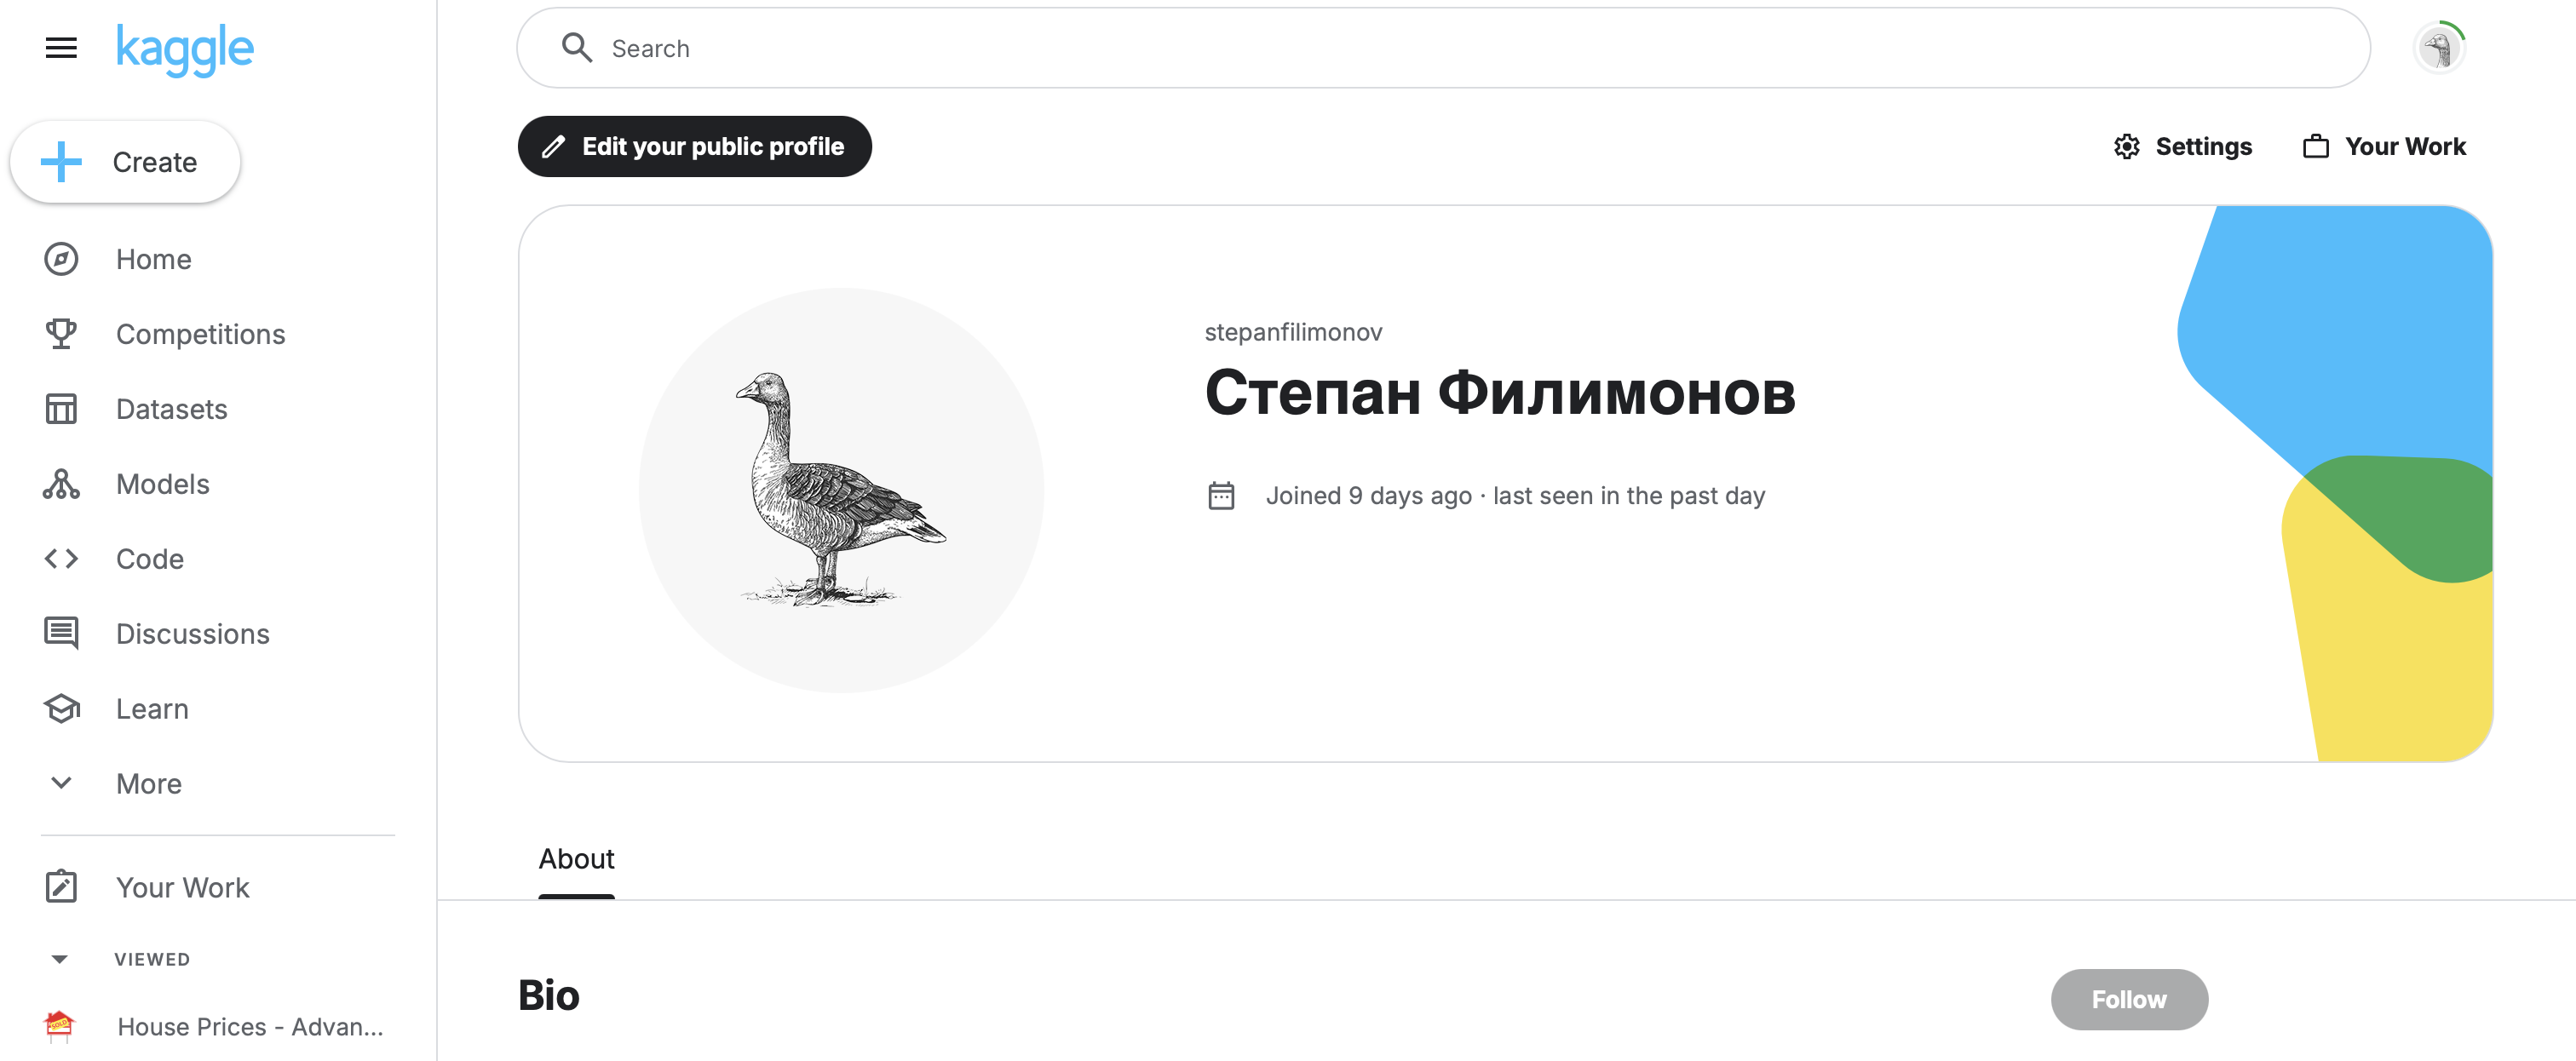

## № 2 Вспомогательные ячейки для решения основной части домашнего задания

In [1]:
# https://drive.google.com/file/d/1F6f-h3x96H_ayoYek4OYaZc00YYlOJJ2/view?usp=sharing # материалы для домашнего задания на гугл диске

In [1]:
!gdown 1F6f-h3x96H_ayoYek4OYaZc00YYlOJJ2

zsh:1: command not found: gdown


In [3]:
!tar -xf asr_hw_1.tar

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'


In [9]:
!ls -l asr_hw_1/

total 1632
-rw-r--r--@ 1 stepanfilimonov  staff  354918 12 ноя 23:22 alphas.txt
-rw-r--r--@ 1 stepanfilimonov  staff  354076 12 ноя 23:22 betas.txt
-rw-r--r--@ 1 stepanfilimonov  staff  119625 12 ноя 23:22 test_matrix.txt


In [7]:
!pip install editdistance librosa torchaudio

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 2.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0
    Uninstalling torch-2.5.0:
      Successfully uninstalled torch-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.0 requires torch==2.5.0, but you have torch 2.5.1 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import math
import os
import string

from typing import List

import editdistance
import librosa
import numpy as np
import torch
import torch.nn.functional as F
import torchaudio

from IPython import display
from matplotlib import pyplot as plt
from torch import distributions
from torch import nn

Вспомогательные функции

In [3]:
# вспомогательные функции
BLANK_SYMBOL = "_"

class Tokenizer:
    """
    Maps characters to integers and vice versa
    """
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for i, ch in enumerate(["'", " "] + list(string.ascii_lowercase) + [BLANK_SYMBOL]):
            self.char_map[ch] = i
            self.index_map[i] = ch

    def text_to_indices(self, text: str) -> List[int]:
        return [self.char_map[ch] for ch in text]

    def indices_to_text(self, labels: List[int]) -> str:
        return "".join([self.index_map[i] for i in labels])

    def get_symbol_index(self, sym: str) -> int:
        return self.char_map[sym]


tokenizer = Tokenizer()

NEG_INF = -float("inf")


def logsumexp(*args) -> float:
    """
    Log-sum-exp trick for log-domain calculations
    See for details: https://en.wikipedia.org/wiki/LogSumExp
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max) for a in args))
    return a_max + lsp


def modify_sequence(sequence: List[int], blank_idx: int) -> List[int]:
    """
    Modifies sequence which with START, END blanks and between each character
    """
    modified_sequence = []

    for idx in sequence:
        modified_sequence += [blank_idx, idx]

    modified_sequence.append(blank_idx)
    return modified_sequence

# Загрузим вероятности и матрицы альфа и бета
matrix = np.loadtxt(os.path.join('asr_hw_1', 'test_matrix.txt'))
labels_indices = tokenizer.text_to_indices('there se ms no good reason for believing that twillc ange')
ref_alphas = np.loadtxt(os.path.join('asr_hw_1', 'alphas.txt'))
ref_betas = np.loadtxt(os.path.join('asr_hw_1', 'betas.txt'))

## № 2.1 Forward algorithm (4 балла)


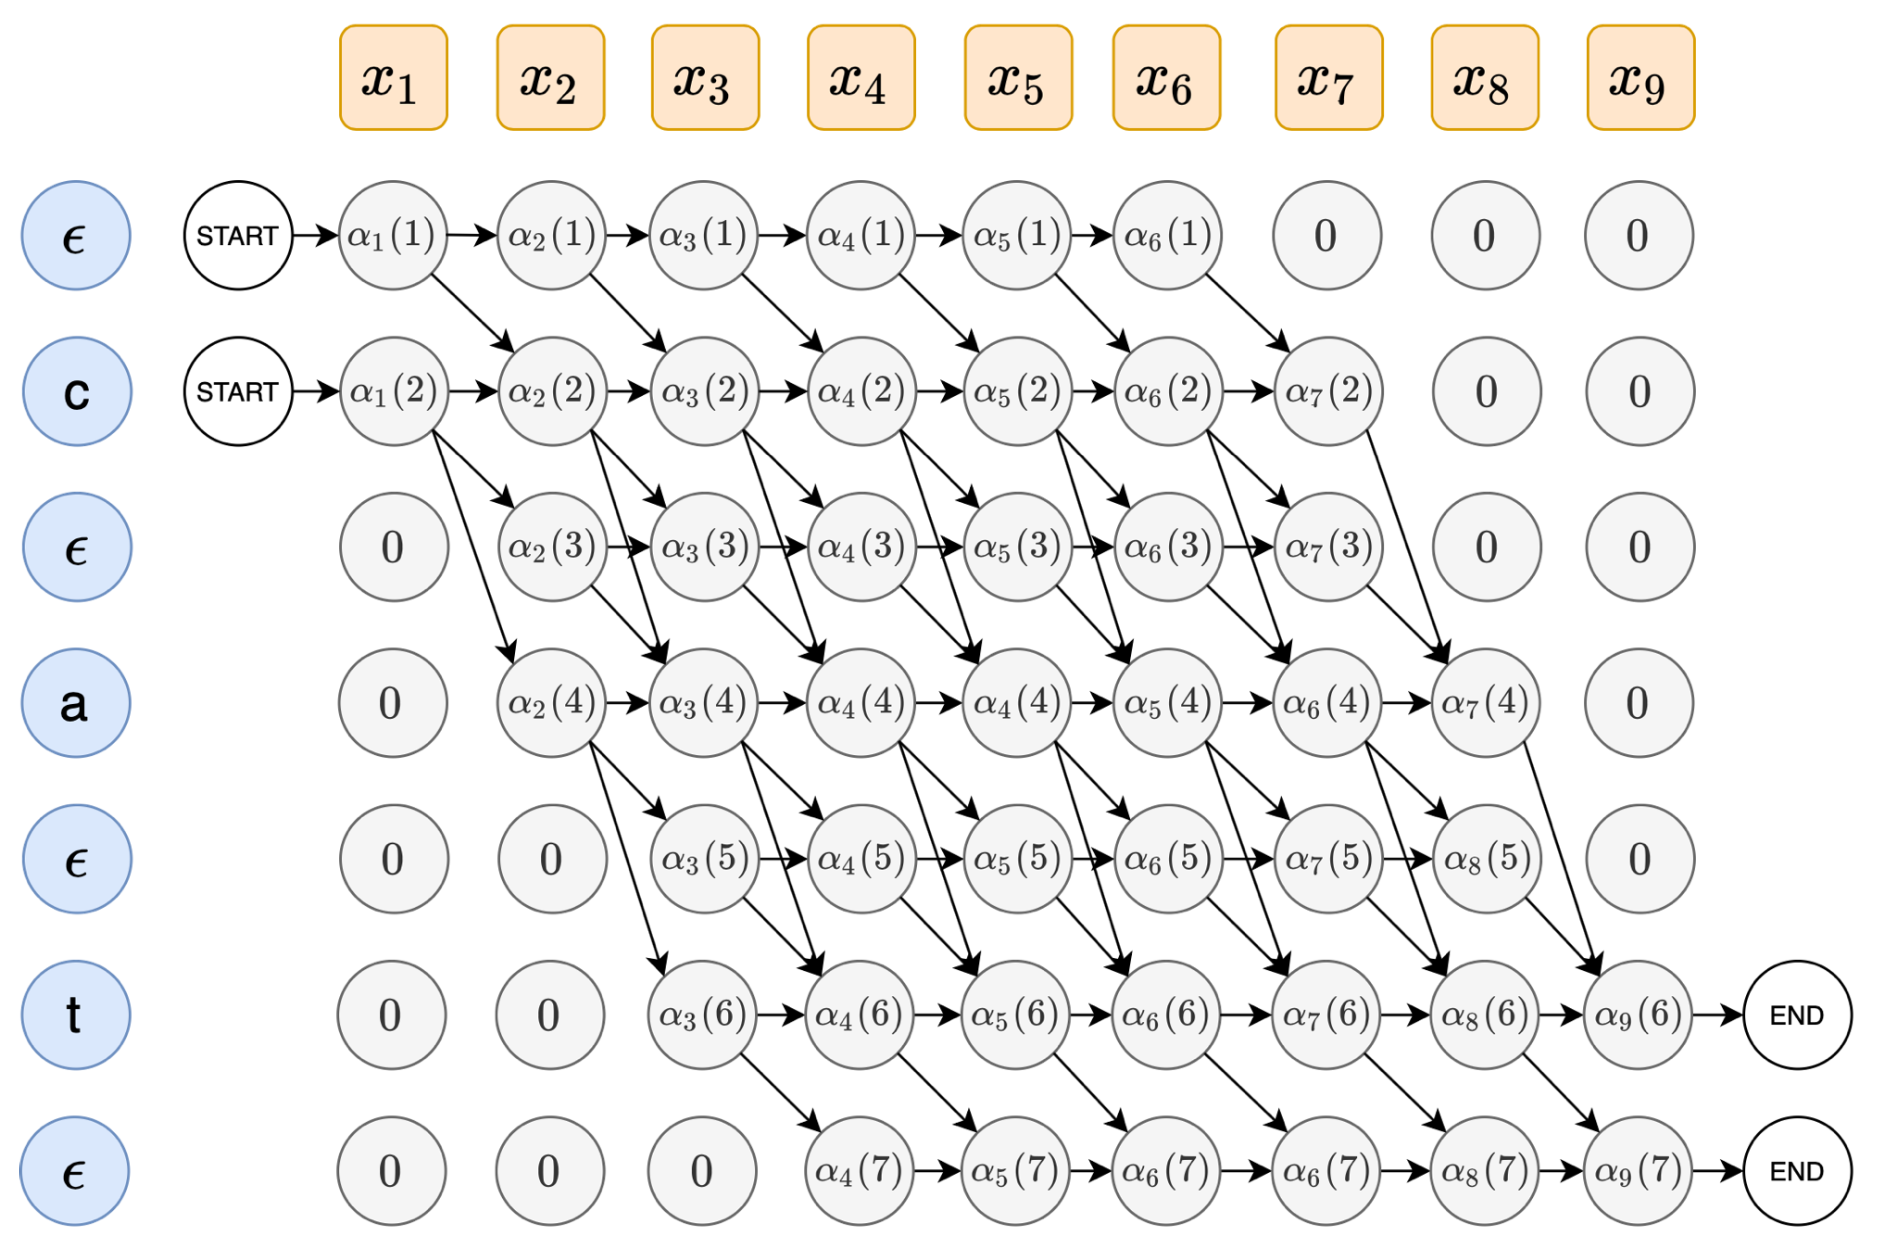

Будут полезны материалы [отсюда](https://docs.google.com/presentation/d/12gYcPft9_4cxk2AD6Z6ZlJNa3wvZCW1ms31nhq51vMk/pub?start=false&loop=false&delayms=3000&slide=id.g24e9f0de4f_0_1095) и [отсюда](https://distill.pub/2017/ctc/)

**Начальная инициализация** Валидные префиксы могут начинаться либо с бланк токена($\epsilon$) либо с первого токена в последовательности $\omega_{1:L}$. Так же для всех вершин, для которых выполняется соотношение $s < (2L + 1) - 2(T - t) - 1$ справедливо $\alpha_t(s) = 0$, потому что для этих вершин не хватит хидденов (временных компонент), чтобы прийти в корректные конечные точки валидной последовательности. \
**Подсказка**: поскольку индексация по массиву начинается с нуля, необходимо подумать, как будет выглядеть условие для "недостижимых" вершин на Python.

Таким образом получаем правило инициализации

$$
  \begin{aligned}
    &\alpha_t(0) = 0, \forall t & \\
    &\alpha_1(1) = P(z_1 = \epsilon | \mathbf{X}_{1:T}), &\\
    &\alpha_1(2) = P(z_1 = \omega^{'}_2 | \mathbf{X}_{1:T}), &\\
    &\alpha_1(s) = 0,\ \forall s > 2 &\\
    &\alpha_t(s) = 0,\ \forall s < (2L + 1) - 2(T - t) - 1 &  \text{вершины, из которых уже не получится дойти до валидного конца}\\
  \end{aligned}
$$

**Рекурсивное правило**

$$
  \begin{aligned}
    &\alpha_t(s) = \left \{
  \begin{aligned}
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) \big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{если}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s-2}^{'} \\
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) + \alpha_{t-1}(s-2)\big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{в противном случае}\\
  \end{aligned} \right.
  \end{aligned}
$$

In [4]:
def forward_algorithm(sequence: List[int], matrix: List[List[float]]) -> List[List[float]]:
    """
    :param sequence: a string converted to an index array
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the forward pass of shape (2 * len(sequence) + 1, T)
    """
    matrix = np.log(matrix)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)    
    mod_sequence = modify_sequence(sequence, blank)
    
    T = matrix.shape[1]    # T - количество временных шагов
    L = len(mod_sequence)  # L - длина модифицированной последовательности
    X = len(sequence) - T  # X - Для уравнения ограничения справа
    alphas = np.full([L, T], NEG_INF)
    
    for t in range(T):
        for s in range(L):
            if t == 0:
                if s < 2:
                    alphas[s, t] = matrix[mod_sequence[s], t]
                else:
                    break
            elif s < 2 * (t + X) + 1:
                alphas[s][t] = NEG_INF
            else:
                if s == 0:
                    alphas[s][t] = alphas[s][t-1] + matrix[mod_sequence[s], t]
                elif s == 1:
                    alphas[s][t] = logsumexp(alphas[s-1][t-1], alphas[s][t-1]) + matrix[mod_sequence[s], t]
                else:
                    if (mod_sequence[s] == mod_sequence[s-2]) or (mod_sequence[s] == blank):
                        alphas[s, t] = logsumexp(alphas[s-1, t-1], alphas[s][t-1]) + matrix[mod_sequence[s], t]
                    else:
                        alphas[s, t] = logsumexp(alphas[s-2, t-1], alphas[s-1, t-1], alphas[s][t-1]) + matrix[mod_sequence[s], t]
    return alphas

Если последнее значение будет не равно True, значит где-то выше возникла ошибка

In [5]:
alphas = forward_algorithm(labels_indices, matrix)
alphas == ref_alphas

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Следующая ячейка кода поможет вам отдебажить код выше (в случае, если возникли проблемы с его написанием)

In [6]:
alphas = forward_algorithm(labels_indices, matrix)

incorrect_elements = np.nonzero(~np.isclose(ref_alphas, alphas))
if incorrect_elements[1].shape[0]:
    index = np.argmin(incorrect_elements[1])
    incorrect_indices = (incorrect_elements[0][index], incorrect_elements[1][index])
    print((
        f'Leftmost incorrect time layer is t={incorrect_elements[1][index]}\n'
        f'Your alphas[{incorrect_indices[0]}, {incorrect_indices[1]}] = {alphas[incorrect_indices]:.5f}\t'
        f'Reference alphas[{incorrect_indices[0]}, {incorrect_indices[1]}] = {ref_alphas[incorrect_indices]:.5f}'
    ))

assert np.allclose(ref_alphas[:, 0], alphas[:, 0]), "Bad initialization of the first layer of alphas (t = 0)"
assert np.allclose(ref_alphas[0, :], alphas[0, :]), "Bad calculation of the first elemenent (probability of all-blank sequence '<blank>...<blank>') of the each layer"
assert np.allclose(ref_alphas[1, :], alphas[1, :]), "Bad calculation of the second elemenent (probability of sequence '<blank>...<blank><first_token>') of the each layer"
assert np.allclose(ref_alphas[::2, :], alphas[::2, :]), "Bad calculation of alphas for the blank tokens"
assert np.allclose(ref_alphas, alphas), "Your alphas matrix is not close enough to the reference one"

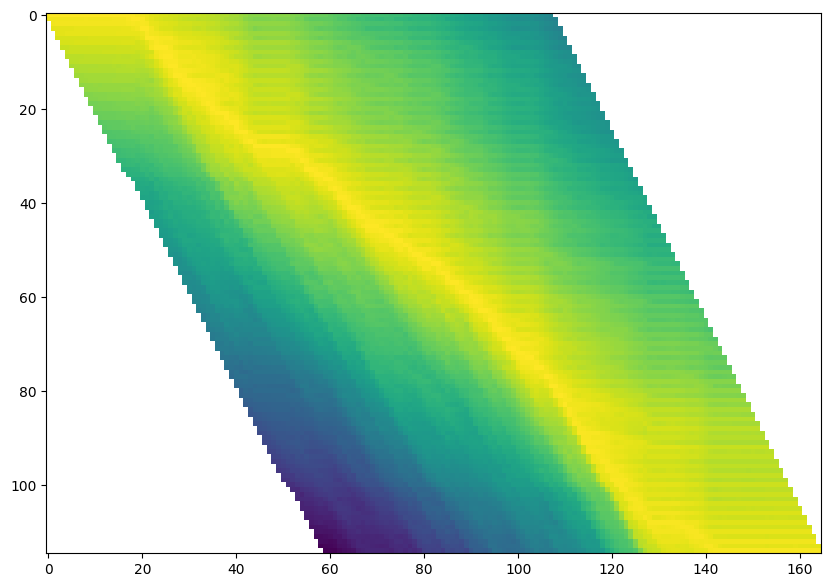

In [7]:
plt.figure(figsize=(10, 8))
plt.imshow(alphas)
plt.show()

## № 2.2 Backward algorithm (4 балла)

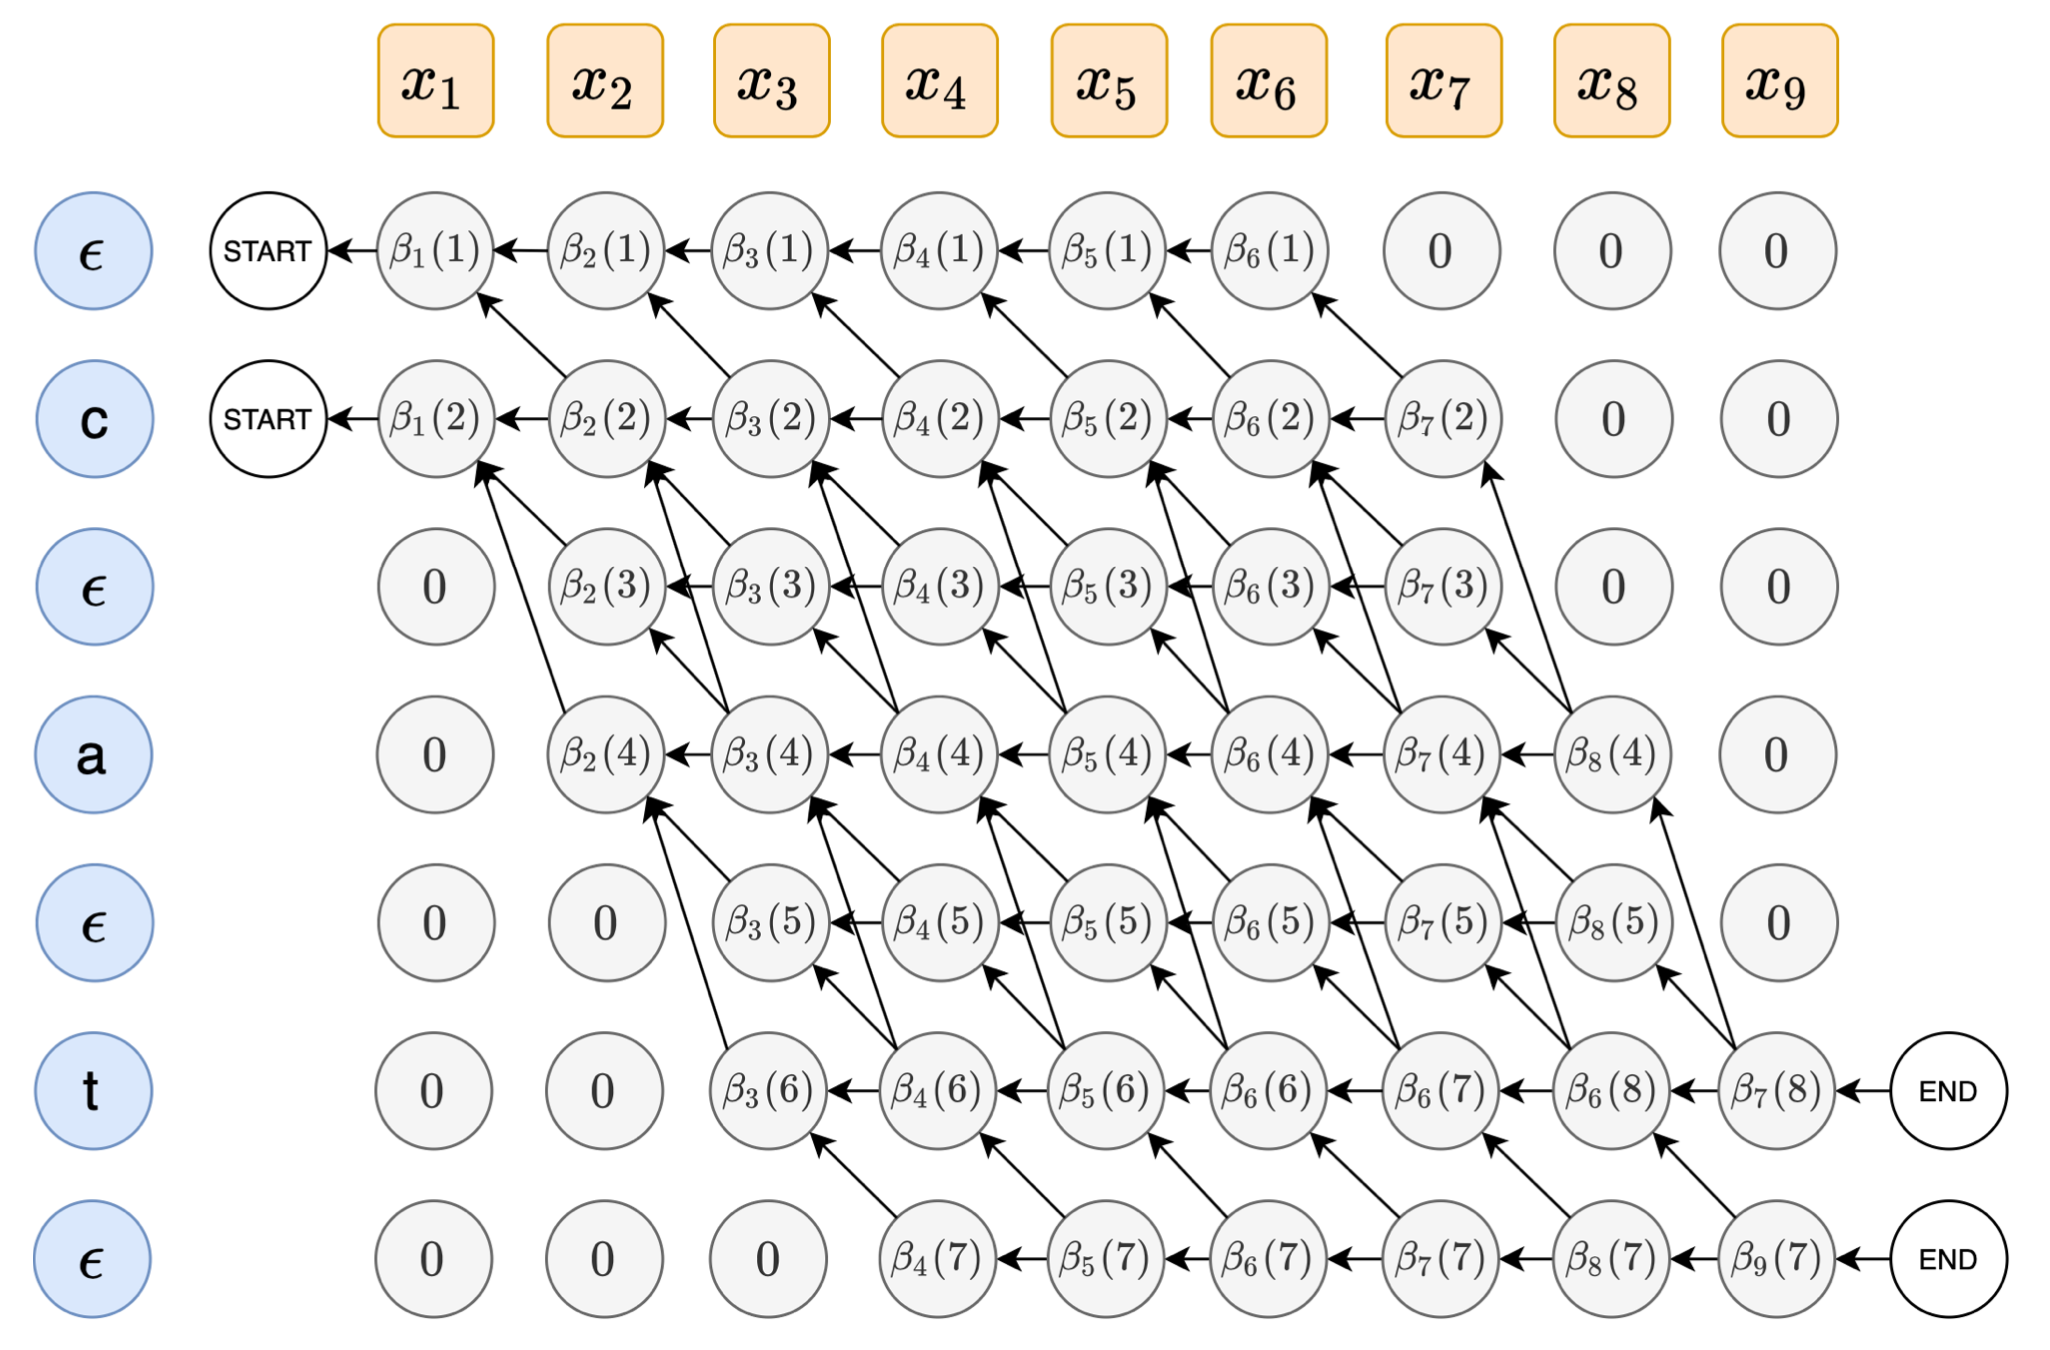

Будут полезны материалы [отсюда](https://docs.google.com/presentation/d/12gYcPft9_4cxk2AD6Z6ZlJNa3wvZCW1ms31nhq51vMk/pub?start=false&loop=false&delayms=3000&slide=id.g24e9f0de4f_0_1095) и [отсюда](https://distill.pub/2017/ctc/)

$$
  \begin{aligned}
    &\beta_T(2L+1) = 1 &\\
    &\beta_T(2L) = 1 & \\
    &\beta_T(s) = 0, \forall s < 2L &\\
    &\beta_t(s) = 0,\ \forall s > 2t &\\
    &\beta_t(2L+2) = 0,\ \forall t  & \text{недостижимые вершини слева} \\
    &\beta_t(s) = \left \{
      \begin{aligned}
        &\beta_{t+1}(s) P(z_{t + 1} = \omega^{'}_s | \mathbf{X}_{1:T}) + \beta_{t+1}(s+1) P(z_{t + 1} = \omega^{'}_{s + 1} | \mathbf{X}_{1:T})  & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
        \omega_s^{'} = \omega_{s+2}^{'} \\
        &\beta_{t+1}(s) P(z_{t + 1} = \omega^{'}_s | \mathbf{X}_{1:T}) + \beta_{t+1}(s+1) P(z_{t + 1} = \omega^{'}_{s + 1} | \mathbf{X}_{1:T}) + \beta_{t+1}(s+2) P(z_{t + 1} = \omega^{'}_{s + 2} | \mathbf{X}_{1:T}) & \text{в противном случае}\\
      \end{aligned}\right.
  \end{aligned}
$$


In [8]:
def backward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the backward pass of shape (2 * len(sequence) + 1, T)
    """
    matrix = np.log(matrix)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)

    T = matrix.shape[1]      # T - количество временных шагов
    L = len(mod_sequence)    # L - длина модифицированной последовательности
    betas = np.full([L, T], NEG_INF)

    for s in range(L - 1, -1, -1):
        for t in range(T - 1, -1, -1):
            if t == (T - 1):
                betas[s, t] = 0 if s > (L - 3) else NEG_INF
            elif s > (2 * t + 1):
                betas[s, t] = NEG_INF
            else:
                j = t + 1
                i_ms = mod_sequence[s]
                if s == L - 1:
                    betas[s, t] = logsumexp(betas[s, j] + matrix[i_ms, j])
                elif s == L - 2:
                    betas[s, t] = logsumexp(betas[s, j] + matrix[i_ms, j], betas[s + 1, j] + matrix[mod_sequence[s + 1], j])
                else:
                    i_ms1, i_ms2 = mod_sequence[s + 1], mod_sequence[s + 2]
                    if (i_ms == blank) or (i_ms == i_ms2):
                        betas[s, t] = logsumexp(betas[s, j] + matrix[i_ms, j], betas[s + 1, j] + matrix[i_ms1, j])
                    else:
                        betas[s, t] = logsumexp(betas[s, j] + matrix[i_ms, j], betas[s + 1, j] + matrix[i_ms1, j],
                                                betas[s + 2, j] + matrix[i_ms2, j])
                
    return betas

Если последнее в углах будет не равно True, значит где-то выше возникла ошибка

In [9]:
betas = backward_algorithm(labels_indices, matrix)
betas == ref_betas

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Следующая ячейка кода поможет вам отдебажить код выше (в случае, если возникли проблемы с его написанием)

In [10]:
betas = backward_algorithm(labels_indices, matrix)

incorrect_elements = np.nonzero(~np.isclose(ref_betas, betas))
if incorrect_elements[1].shape[0]:
    index = np.argmax(incorrect_elements[1])
    incorrect_indices = (incorrect_elements[0][index], incorrect_elements[1][index])
    print((
        f'Rightmost incorrect time layer is t={incorrect_elements[1][index]}\n'
        f'Your betas[{incorrect_indices[0]}, {incorrect_indices[1]}] = {betas[incorrect_indices]:.5f}\t'
        f'Reference betas[{incorrect_indices[0]}, {incorrect_indices[1]}] = {ref_betas[incorrect_indices]:.5f}'
    ))

assert np.allclose(ref_betas[:, -1], betas[:, -1]), "Bad initialization of the last layer of betas (t = matrix.shape[1] - 1)"
assert np.allclose(ref_betas[-1, :], betas[-1, :]), "Bad calculation of the last elemenent (probability of all-blank sequence '<blank>...<blank>') of the each layer"
assert np.allclose(ref_betas[-2, :], betas[-2, :]), "Bad calculation of the second-to-last elemenent (probability for the sequence '<last_token><blank>...<blank>') of the each layer"
assert np.allclose(ref_betas[::2, :], betas[::2, :]), "Bad calculation of betas for the blank tokens"
assert np.allclose(ref_betas, betas), "Your betas matrix is not close enough to the reference one"

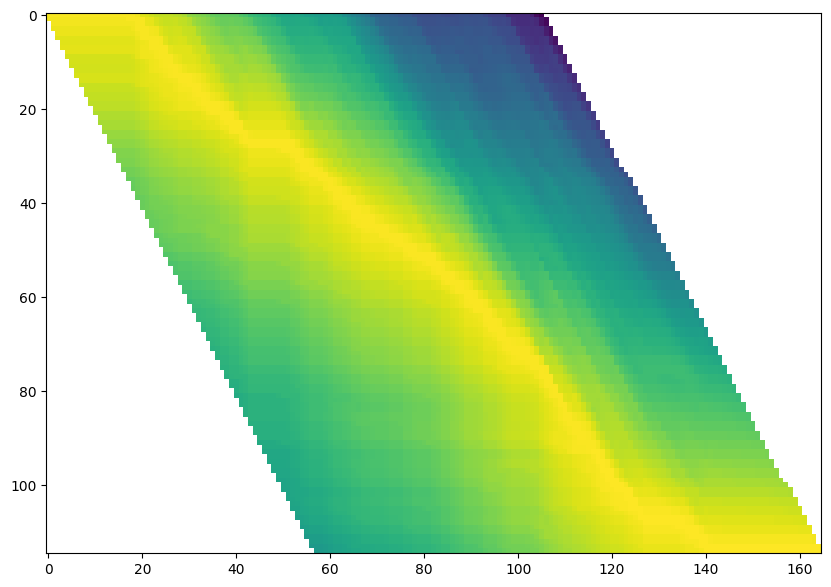

In [11]:
plt.figure(figsize=(10, 8))
plt.imshow(betas)
plt.show()